LGMVIP DS MARCH 2023

Stock Market Prediction and Forecasting using Stacked LSTM

In [29]:
import pandas as pd

df = pd.read_csv('AAPL.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099722,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094519,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087582,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089749,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092351,73449600
...,...,...,...,...,...,...,...
10652,2023-03-15,151.190002,153.250000,149.919998,152.990005,152.990005,77167900
10653,2023-03-16,152.160004,156.460007,151.639999,155.850006,155.850006,76161100
10654,2023-03-17,156.080002,156.740005,154.279999,155.000000,155.000000,98862500
10655,2023-03-20,155.070007,157.820007,154.149994,157.399994,157.399994,73641400


In [10]:
df = df[['Date', 'Close']]

df

,Date,Close
0,1980-12-12,0.128348
1,1980-12-15,0.121652
2,1980-12-16,0.112723
3,1980-12-17,0.115513
4,1980-12-18,0.118862
...,...,...
10652,2023-03-15,152.990005
10653,2023-03-16,155.850006
10654,2023-03-17,155.000000
10655,2023-03-20,157.399994


In [11]:
df['Date']

0        1980-12-12
1        1980-12-15
2        1980-12-16
3        1980-12-17
4        1980-12-18
            ...    
10652    2023-03-15
10653    2023-03-16
10654    2023-03-17
10655    2023-03-20
10656    2023-03-21
Name: Date, Length: 10657, dtype: object

In [12]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1980-12-18')
datetime_object

datetime.datetime(1980, 12, 18, 0, 0)

In [14]:
df

,Date,Close
0,1980-12-12,0.128348
1,1980-12-15,0.121652
2,1980-12-16,0.112723
3,1980-12-17,0.115513
4,1980-12-18,0.118862
...,...,...
10652,2023-03-15,152.990005
10653,2023-03-16,155.850006
10654,2023-03-17,155.000000
10655,2023-03-20,157.399994


In [15]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

/var/folders/t9/q352d67111n132g188862whw0000gn/T/ipykernel_87297/2565755782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0       1980-12-12
1       1980-12-15
2       1980-12-16
3       1980-12-17
4       1980-12-18
           ...    
10652   2023-03-15
10653   2023-03-16
10654   2023-03-17
10655   2023-03-20
10656   2023-03-21
Name: Date, Length: 10657, dtype: datetime64[ns]

In [16]:
df.index = df.pop('Date')
df

,Close
Date,
1980-12-12,0.128348
1980-12-15,0.121652
1980-12-16,0.112723
1980-12-17,0.115513
1980-12-18,0.118862
...,...
2023-03-15,152.990005
2023-03-16,155.850006
2023-03-17,155.000000


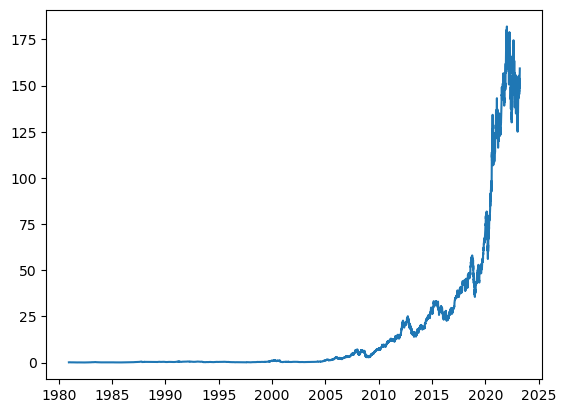

In [17]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [18]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2022-03-23', 
                                '2023-03-21', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2022-03-23,163.979996,165.380005,168.820007,170.210007
1,2022-03-24,165.380005,168.820007,170.210007,174.070007
2,2022-03-25,168.820007,170.210007,174.070007,174.720001
3,2022-03-28,170.210007,174.070007,174.720001,175.600006
4,2022-03-29,174.070007,174.720001,175.600006,178.960007
...,...,...,...,...,...
245,2023-03-15,148.500000,150.470001,152.589996,152.990005
246,2023-03-16,150.470001,152.589996,152.990005,155.850006
247,2023-03-17,152.589996,152.990005,155.850006,155.000000
248,2023-03-20,152.990005,155.850006,155.000000,157.399994


In [19]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((250,), (250, 3, 1), (250,))

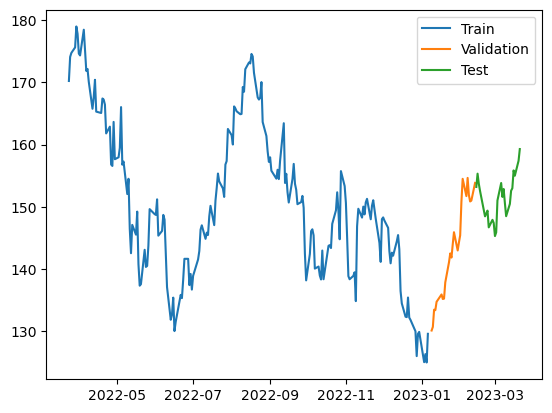

In [20]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100


2023-03-22 14:08:58.962580: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-22 14:08:59.490144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-22 14:08:59.641488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-22 14:09:00.397237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 3s 130ms/step - loss: 22769.0117 - mean_absolute_error: 150.3685 - val_loss: 20265.8984 - val_mean_absolute_error: 142.1453
Epoch 2/100
6/7 [========================>.....] - ETA: 0s - loss: 22579.3086 - mean_absolute_error: 149.7287

2023-03-22 14:09:01.696159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-22 14:09:01.740616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 13ms/step - loss: 22592.7969 - mean_absolute_error: 149.7819 - val_loss: 20071.7500 - val_mean_absolute_error: 141.4608
Epoch 3/100
7/7 [==============================] - 0s 13ms/step - loss: 22383.5098 - mean_absolute_error: 149.0827 - val_loss: 19877.3262 - val_mean_absolute_error: 140.7717
Epoch 4/100
7/7 [==============================] - 0s 13ms/step - loss: 22165.5039 - mean_absolute_error: 148.3470 - val_loss: 19631.4590 - val_mean_absolute_error: 139.8954
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 21881.0547 - mean_absolute_error: 147.3831 - val_loss: 19303.9512 - val_mean_absolute_error: 138.7188
Epoch 6/100
7/7 [==============================] - 0s 12ms/step - loss: 21473.6270 - mean_absolute_error: 145.9971 - val_loss: 18779.5215 - val_mean_absolute_error: 136.8153
Epoch 7/100
7/7 [==============================] - 0s 12ms/step - loss: 20842.2637 - mean_absolute_error: 143.8144 - val_loss: 18109.0137 - va

7/7 [==============================] - 0s 6ms/step


2023-03-22 14:09:26.583191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-22 14:09:26.617879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


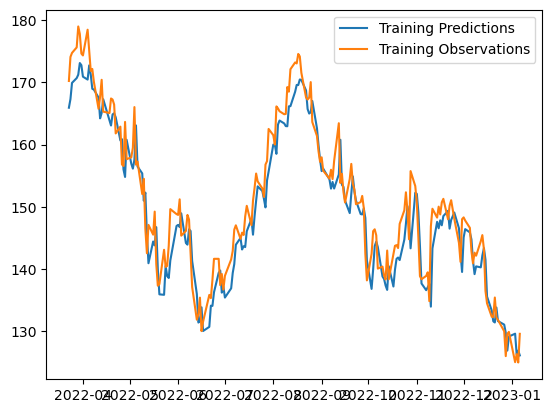

In [22]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 25ms/step


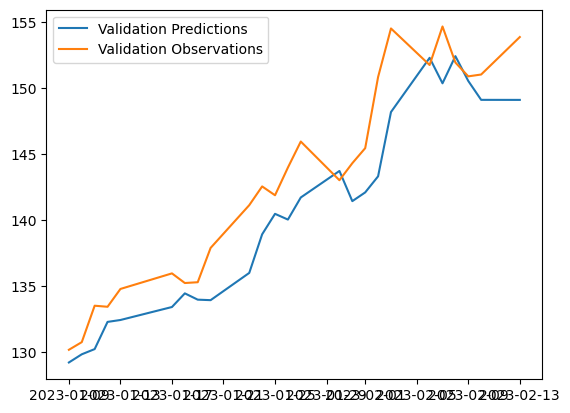

In [23]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 11ms/step


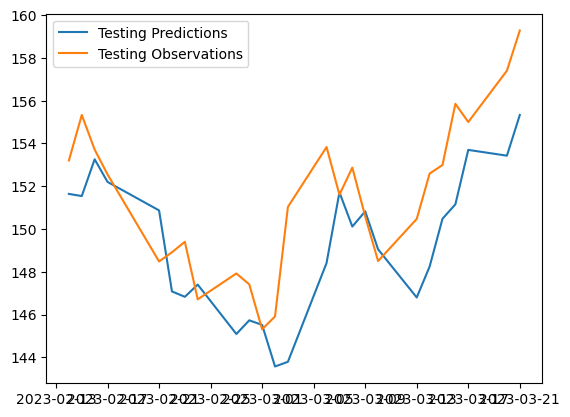

In [24]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

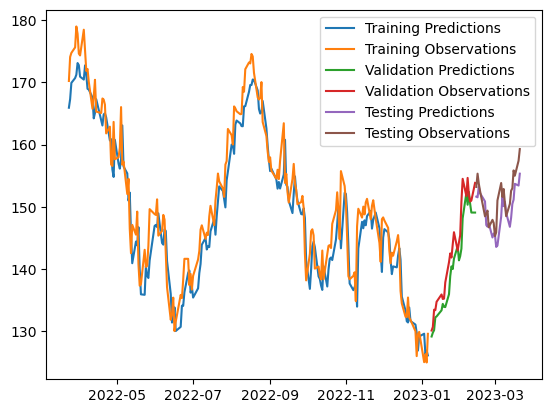

In [25]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [26]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 10ms/step


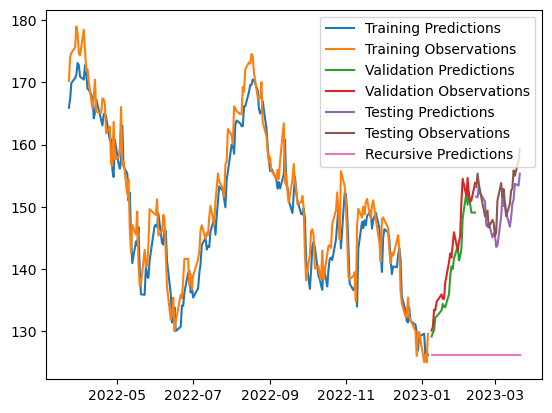

In [27]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])